<a href="https://colab.research.google.com/github/ekttd/VAST-Challenge/blob/main/VAST_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Загрузка данных**

In [1]:
import pandas as pd

In [2]:
friday_url = "https://github.com/ekttd/VAST-Challenge/raw/main/MC2%202015%20Data/comm-data-Fri.csv"
df = pd.read_csv(friday_url)
df.head()

,Timestamp,from,to,location
0,2014-6-06 08:03:19,439105,1053224,Kiddie Land
1,2014-6-06 08:03:19,439105,1696241,Kiddie Land
2,2014-6-06 08:03:19,439105,580064,Kiddie Land
3,2014-6-06 08:03:19,439105,1464748,Kiddie Land
4,2014-6-06 08:03:47,1836139,1593258,Entry Corridor


# **Преобразование данных**

---
Добавлены интервалы по 15 минут для визуалаизации


In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# вообще Timestamp и так был datetime, но почему-то
# без явного преобразования дальше не работает(

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
start_time = df['Timestamp'].iloc[0]

start_hour = start_time.floor('h') # округление до начала часа
# сколько минут прошло от первой записи
minutes_from_start = (df['Timestamp'] - start_hour).dt.total_seconds() // 60

# метка интервала - делим всю колонку на 15, получается номер интервала
df['quarter'] = (minutes_from_start // 15 + 1).astype(int)

df[1430:1440]

,Timestamp,from,to,location,quarter
1430,2014-06-06 08:14:53,824453,148882,Kiddie Land,1
1431,2014-06-06 08:14:53,1371106,1846280,Kiddie Land,1
1432,2014-06-06 08:14:56,973062,196239,Entry Corridor,1
1433,2014-06-06 08:14:56,973062,919935,Entry Corridor,1
1434,2014-06-06 08:14:58,96972,1607917,Entry Corridor,1
1435,2014-06-06 08:14:58,96972,1205461,Entry Corridor,1
1436,2014-06-06 08:14:58,96972,1492555,Entry Corridor,1
1437,2014-06-06 08:15:00,643918,918404,Wet Land,2
1438,2014-06-06 08:15:01,755524,217150,Tundra Land,2
1439,2014-06-06 08:15:01,755524,947320,Tundra Land,2


In [5]:
df['hour'] = df['Timestamp'].dt.hour
df['minute'] = df['Timestamp'].dt.minute
df = df.drop(columns=['Timestamp'])
df.head()

,from,to,location,quarter,hour,minute
0,439105,1053224,Kiddie Land,1,8,3
1,439105,1696241,Kiddie Land,1,8,3
2,439105,580064,Kiddie Land,1,8,3
3,439105,1464748,Kiddie Land,1,8,3
4,1836139,1593258,Entry Corridor,1,8,3


In [6]:
# количество сообщений в каждую четверть
quarters_intence = df['quarter'].value_counts().sort_index()
quarters_intence.head()

,count
quarter,
1,1437
2,5029
3,7539
4,10679
5,12377


In [7]:
values = quarters_intence.values
intervals = quarters_intence.index

start_minutes = df.loc[0, 'hour'] * 60 + df.loc[0, 'minute']

labels = []

for q in intervals:
    start_time = start_hour + pd.Timedelta(minutes=(q - 1) * 15)
    end_time = start_time + pd.Timedelta(minutes=15)

    labels.append(
        f"{start_time.strftime('%H:%M')}-{end_time.strftime('%H:%M')}"
    )

if values.max() == values.min():
    norm = np.zeros_like(values)
else:
    norm = (values - values.min()) / (values.max() - values.min())

colors = plt.cm.YlOrRd(norm)

equal_parts = np.ones(len(values))

## Круговая диаграмма с легендой

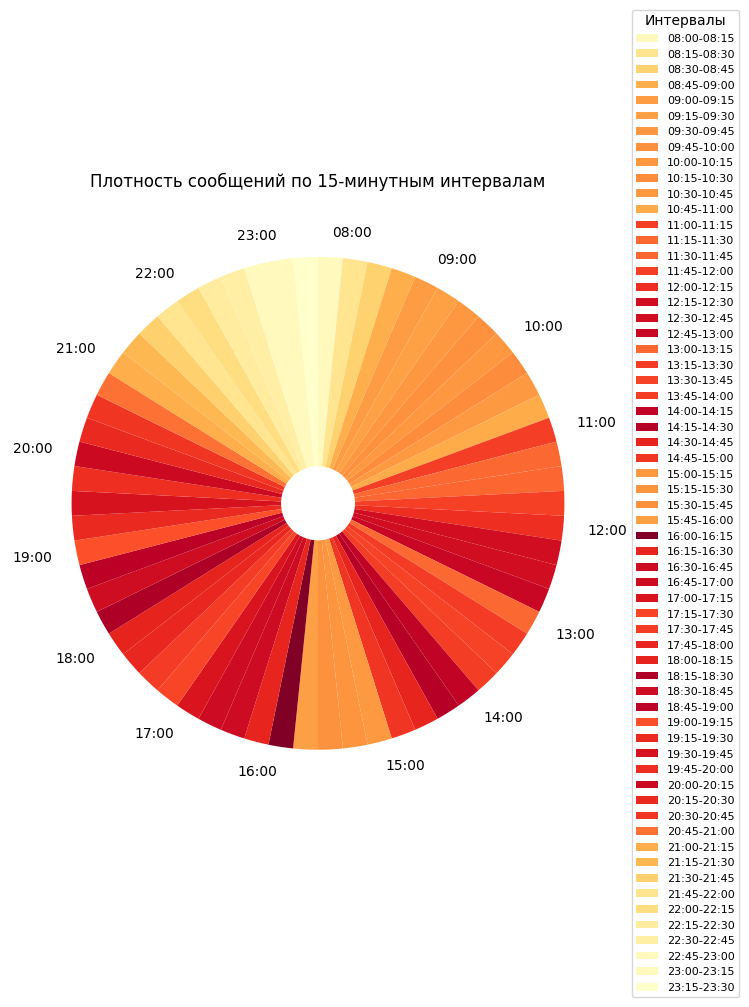

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

step_for_clock_labels = 4
clock_labels = [
    (start_hour + pd.Timedelta(minutes=(q-1)*15)).strftime('%H:%M')
    if (q-1) % step_for_clock_labels == 0 else ""
    for q in intervals
]

wedges, _ = ax.pie(
    equal_parts,
    labels=clock_labels,
    colors=colors,
    wedgeprops=dict(width=0.85),
    counterclock=False,
    startangle=90
)
ax.legend(
    wedges,
    labels,
    title="Интервалы",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=8
)


plt.title("Плотность сообщений по 15-минутным интервалам")

plt.show()

## Просто круговая диаграмма

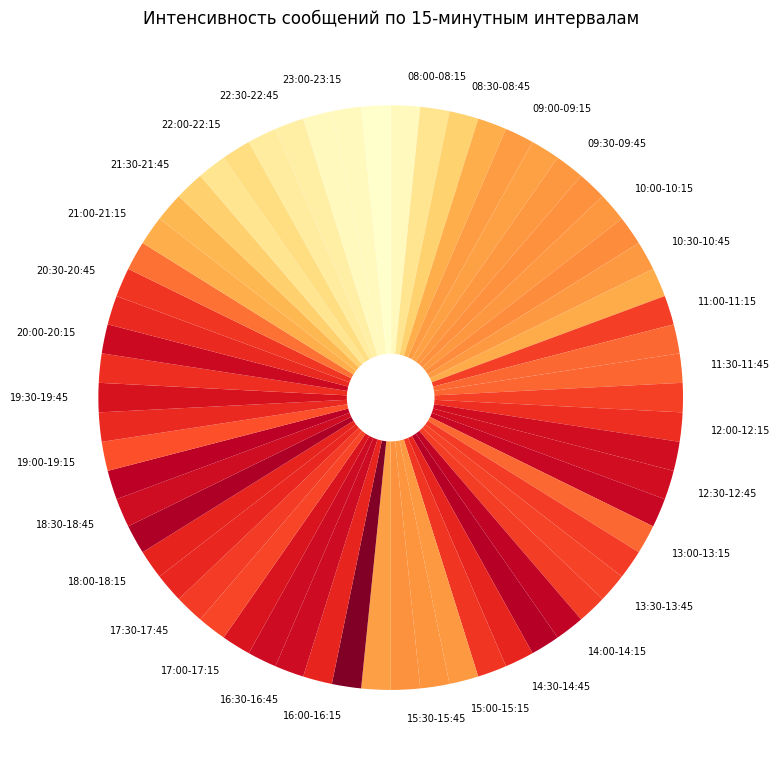

In [9]:
step = 2

filtered_labels = [
    label if i % step == 0 else ""
    for i, label in enumerate(labels)
]

plt.figure(figsize=(8, 8))

plt.pie(
    equal_parts,
    labels=filtered_labels,
    colors=colors,
    wedgeprops=dict(width=0.85),
    counterclock=False,
    startangle=90,
    textprops={'fontsize': 7}
)

plt.title("Интенсивность сообщений по 15-минутным интервалам")
plt.tight_layout()
plt.show()

## Шкала

---

Удобнее работать с 3 днями


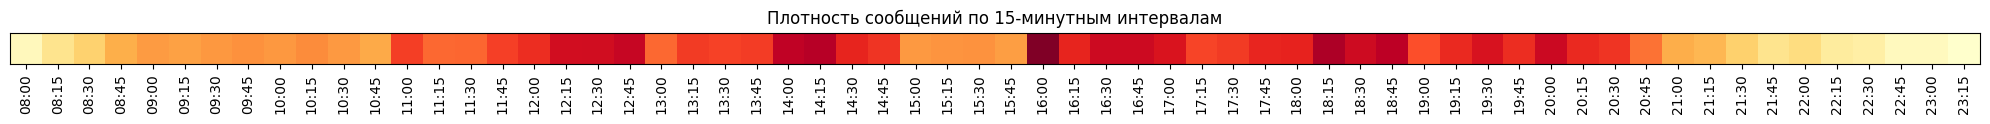

In [34]:
fig, ax = plt.subplots(figsize=(20, 2))

# строка квадратов
ax.imshow([norm], cmap='YlOrRd', aspect='equal')

# подписи времени (как у тебя)
clock_labels = [
    (start_hour + pd.Timedelta(minutes=(q-1)*15)).strftime('%H:%M')
    for q in intervals
]


ax.set_xticks(range(len(intervals)))
ax.set_xticklabels(clock_labels, rotation=90)
ax.set_yticks([])

plt.title("Плотность сообщений по 15-минутным интервалам")
plt.tight_layout()
plt.show()

# Сообщения в локациях

In [11]:
# количество сообщений в каждой локации
location_counts = df.groupby('location').size().sort_values(ascending=False)
location_counts.head()

,0
location,
Wet Land,353319
Entry Corridor,191229
Tundra Land,172764
Coaster Alley,117934
Kiddie Land,113493


In [12]:
# Координаты локаций на карте (в пикселях)

areas = {
    "Tundra Land": (0, 0, 2033, 1800),
    "Entry Corridor": (2040, 0, 2930, 1801),
    "Kiddie Land": (2925, 0, 4041, 1430),
    "Wet Land": (0, 1780, 3313, 2694),
    "Coaster Alley": [(0, 2710, 4020, 2968), (3325, 1418, 4037, 2968)]
}

In [13]:
values = location_counts.values
norm = (values - values.min()) / (values.max() - values.min())

zone_intensity = dict(zip(location_counts.index, norm))

In [14]:
import random

# Генерация случайной точки внутри локации
def random_point(area):
    if isinstance(area, list):
        area = random.choice(area)
    x1, y1, x2, y2 = area
    return random.uniform(x1, x2), random.uniform(y1, y2)

In [15]:
sample_fraction = 0.001
df_sample = df.sample(frac=sample_fraction, random_state=42)

cmap = plt.cm.YlOrRd

xs = []
ys = []
colors = []

for loc in df_sample["location"]:
    if loc in areas:
        x, y = random_point(areas[loc])
        xs.append(x)
        ys.append(y)

        intensity = zone_intensity[loc]
        colors.append(cmap(intensity))

In [16]:
import requests
from PIL import Image
from io import BytesIO

map_url = "https://github.com/ekttd/VAST-Challenge/raw/main/MC2%202015%20Data/map.jpg"
response = requests.get(map_url)
img = Image.open(BytesIO(response.content))

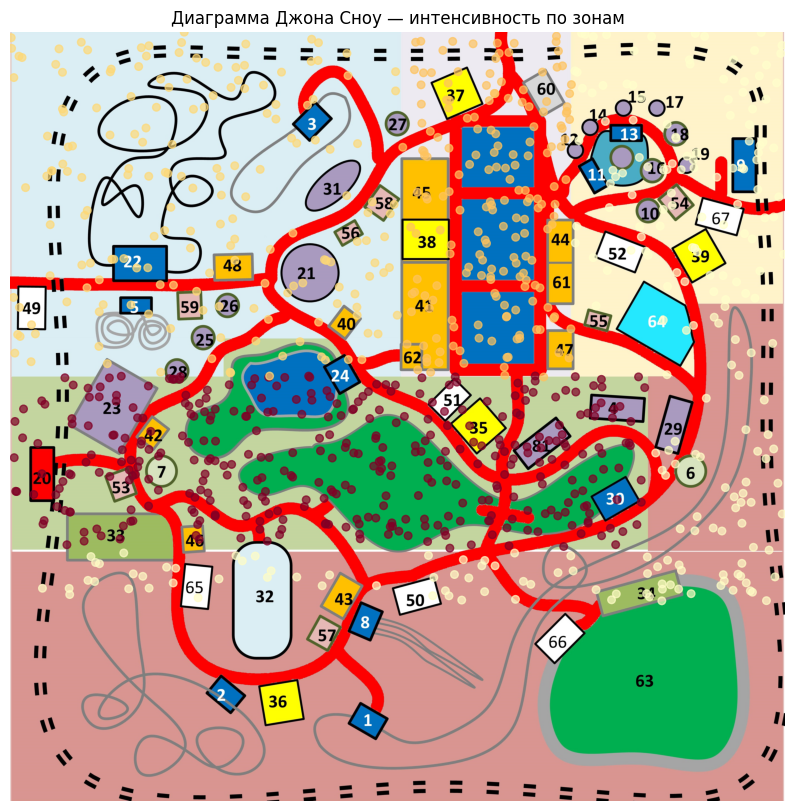

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(img)

plt.scatter(
    xs,
    ys,
    c=colors,
    s=30,
    alpha=0.7
)

plt.title("Диаграмма Джона Сноу — интенсивность по зонам")
plt.axis("off")
plt.show()

## Столбчатая диаграмма


---

С помощью диаграммы можно выделить id, с которых отправлялось больше всего сообщений

In [18]:
massage_counts = df.groupby('from').size().sort_values(ascending=False)
massage_counts.head(10)

,0
from,
1278894,38658
839736,5914
1508923,1896
825466,1850
970490,1686
809736,1631
2047880,1619
124408,1541
33707,1527


Text(0, 0.5, 'Количество')

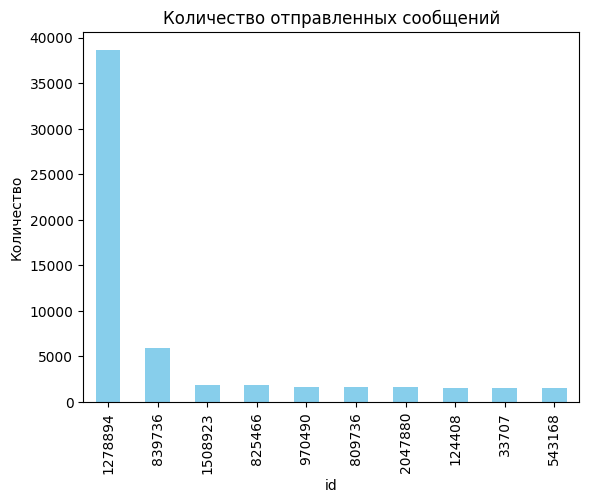

In [19]:
massage_counts.head(10).plot(kind='bar', color='skyblue')
plt.title('Количество отправленных сообщений')
plt.xlabel('id')
plt.ylabel('Количество')

# Выделение сообществ по сообщениям

In [20]:
! pip install python-louvain

In [21]:
import pandas as pd
import networkx as nx
import community as community_louvain

edges = df.groupby(["from", "to"]).size().reset_index(name="weight")

G = nx.from_pandas_edgelist(
    edges,
    source="from",
    target="to",
    edge_attr="weight",
    create_using=nx.Graph()
)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

# поиск сообществ
partition = community_louvain.best_partition(G, weight="weight")

print("Communities found:", len(set(partition.values())))

Nodes: 5876
Edges: 167760
Communities found: 48


In [22]:
communities = pd.DataFrame({
    "user": list(partition.keys()),
    "community": list(partition.values())
})

communities.head()

,user,community
0,941,0
1,101816,1
2,1045980,2
3,1061215,3
4,1098358,4


In [23]:
# Добавили колонки с сообществами

df["from_comm"] = df["from"].map(partition)
df["to_comm"] = df["to"].map(partition)

In [24]:
df.head()

,from,to,location,quarter,hour,minute,from_comm,to_comm
0,439105,1053224,Kiddie Land,1,8,3,0,0
1,439105,1696241,Kiddie Land,1,8,3,0,0
2,439105,580064,Kiddie Land,1,8,3,0,0
3,439105,1464748,Kiddie Land,1,8,3,0,0
4,1836139,1593258,Entry Corridor,1,8,3,34,34


In [25]:
# узлы
group_edges = (
    df[df["from_comm"] != df["to_comm"]]
    .groupby(["from_comm", "to_comm"])
    .size()
    .reset_index(name="messages")
)

In [26]:
import networkx as nx

# граф
G_comm = nx.from_pandas_edgelist(
    group_edges,
    source="from_comm",
    target="to_comm",
    edge_attr="messages",
    create_using=nx.Graph()
)

In [27]:
G_comm = nx.Graph()
for _, row in group_edges.iterrows():
    G_comm.add_edge(row["from_comm"], row["to_comm"], messages=row["messages"])

# размер узлов
community_sizes = df["from_comm"].value_counts()
node_sizes = [np.log1p(community_sizes.get(n, 1)) * 200 for n in G_comm.nodes()]

# цвет узлов
internal_messages = df[df["from_comm"] == df["to_comm"]].groupby("from_comm").size()
node_colors = [np.log1p(internal_messages.get(n, 0)) for n in G_comm.nodes()]
node_colors = np.array(node_colors)
if node_colors.max() > 0:
    node_colors = node_colors / node_colors.max()  # нормализация

# равномерное расположение на окружности
n = len(G_comm.nodes())
angles = np.linspace(0, 2*np.pi, n, endpoint=False)
pos = {node: (np.cos(a), np.sin(a)) for node, a in zip(G_comm.nodes(), angles)}

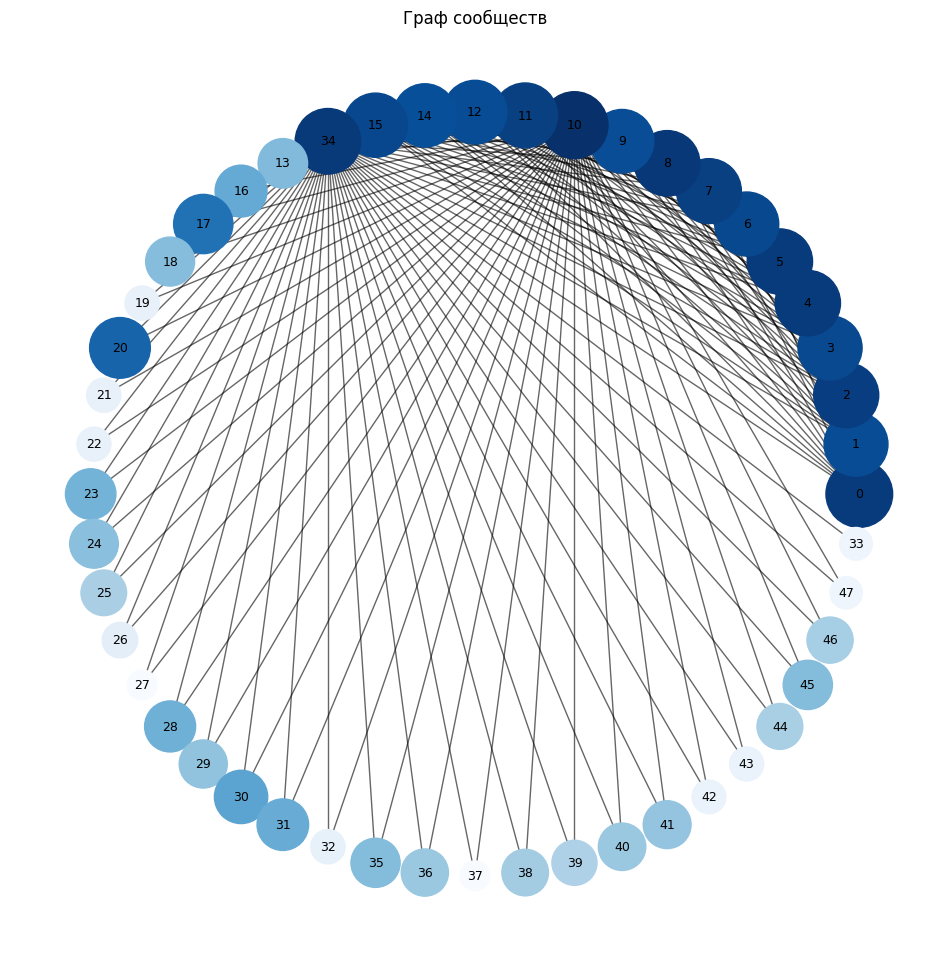

In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(12,12))

# Отрисовка узлов
nodes = nx.draw_networkx_nodes(
    G_comm, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.Blues
)

# Рёбра
nx.draw_networkx_edges(G_comm, pos, alpha=0.6)
# Метки
nx.draw_networkx_labels(G_comm, pos, font_size=9)

plt.title("Граф сообществ")
plt.axis("off")
plt.show()